In [13]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from pyclothoids import Clothoid


from path_trajectory_pkg.path_smoother_clothoids import ClothoidPathSmoother

print("✓ Imports successful")
print("✓ ClothoidPathSmoother loaded")
print("✓ pyclothoids library loaded\n")


✓ Imports successful
✓ ClothoidPathSmoother loaded
✓ pyclothoids library loaded



# Cell 2: Test Waypoints

In [14]:
# Simple test cases
square = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [1.0, 1.0],
    [0.0, 1.0]
])

s_curve = np.array([
    [0.0, 0.0],
    [1.0, 0.0],
    [2.0, 1.0],
    [3.0, 1.0],
    [4.0, 0.0]
])

# Actual robot waypoints
robot_path = np.array([
    [0.0, 0.0],
    [0.374, -6.042],
    [-3.258, -5.959]
])

print("✓ Test waypoints created")
print(f"  - Square: {len(square)} points")
print(f"  - S-curve: {len(s_curve)} points")
print(f"  - Robot path: {len(robot_path)} points\n")


✓ Test waypoints created
  - Square: 4 points
  - S-curve: 5 points
  - Robot path: 3 points



# Cell 3: Test Main Functions

In [15]:
print("="*60)
print("TESTING MAIN FUNCTIONS")
print("="*60)

# Test 1: compute_path_length()
print("\n[Test 1] compute_path_length()")
print("-" * 60)

def compute_path_length(x, y):
    """Compute path length (static method)."""
    dx = np.diff(x)
    dy = np.diff(y)
    return float(np.sum(np.sqrt(dx**2 + dy**2)))

# Test with known distance
x = np.array([0.0, 3.0])
y = np.array([0.0, 4.0])
result = compute_path_length(x, y)
expected = 5.0

print(f"Purpose: Compute total path length")
print(f"Test: 3-4-5 triangle")
print(f"  Expected: {expected:.3f} m")
print(f"  Got:      {result:.3f} m")

if np.isclose(result, expected):
    print("  ✅ PASS")
else:
    print("  ❌ FAIL")

# Test 2: compute_tangent_angles()
print("\n[Test 2] compute_tangent_angles()")
print("-" * 60)

def compute_tangent_angles(waypoints):
    """Compute tangent angles at waypoints for G1 continuity."""
    n = len(waypoints)
    angles = np.zeros(n)
    
    for i in range(n):
        if i == 0:
            # First point: forward difference
            dx = waypoints[i + 1, 0] - waypoints[i, 0]
            dy = waypoints[i + 1, 1] - waypoints[i, 1]
        elif i == n - 1:
            # Last point: backward difference
            dx = waypoints[i, 0] - waypoints[i - 1, 0]
            dy = waypoints[i, 1] - waypoints[i - 1, 1]
        else:
            # Middle points: central difference
            dx_prev = waypoints[i, 0] - waypoints[i - 1, 0]
            dy_prev = waypoints[i, 1] - waypoints[i - 1, 1]
            dx_next = waypoints[i + 1, 0] - waypoints[i, 0]
            dy_next = waypoints[i + 1, 1] - waypoints[i, 1]
            dx = (dx_prev + dx_next) / 2.0
            dy = (dy_prev + dy_next) / 2.0
        
        angles[i] = np.arctan2(dy, dx)
    
    return angles

print(f"Purpose: Compute tangent directions for G1 continuity")
print(f"Method: Forward/backward/central differences")

# Test with square
angles_square = compute_tangent_angles(square)
print(f"\nSquare waypoints:")
for i, angle in enumerate(angles_square):
    print(f"  Point {i}: θ = {np.degrees(angle):6.1f}°")

# Test with horizontal line
horizontal = np.array([[0, 0], [1, 0], [2, 0]])
angles_horiz = compute_tangent_angles(horizontal)

if np.allclose(angles_horiz, 0.0, atol=0.01):
    print(f"\n✅ PASS: Horizontal line has θ ≈ 0°")
else:
    print(f"\n❌ FAIL: Horizontal line angles incorrect")

# Test 3: Clothoid segment generation
print("\n[Test 3] Clothoid Segment Generation")
print("-" * 60)

print(f"Purpose: Create clothoid curve between two points with tangents")
print(f"Method: G1 Hermite interpolation")

# Create a simple clothoid segment
x0, y0 = 0.0, 0.0
x1, y1 = 2.0, 2.0
theta0 = 0.0  # Start horizontal
theta1 = np.pi/2  # End vertical

try:
    clothoid = Clothoid.G1Hermite(x0, y0, theta0, x1, y1, theta1)
    
    print(f"\nClothoid properties:")
    print(f"  Length:        {clothoid.length:.3f} m")
    print(f"  Start curv:    {clothoid.KappaStart:.4f} m⁻¹")
    print(f"  End curv:      {clothoid.KappaEnd:.4f} m⁻¹")
    print(f"  Curv change:   {clothoid.dk:.4f} m⁻²")
    
    # Sample points
    x_samples, y_samples = clothoid.SampleXY(50)
    
    if len(x_samples) == 50:
        print(f"\n✅ PASS: Clothoid created and sampled successfully")
    else:
        print(f"\n❌ FAIL: Sampling returned {len(x_samples)} points instead of 50")
        
except Exception as e:
    print(f"\n❌ FAIL: Clothoid creation failed - {e}")

# Test 4: compute_segment_curvatures()
print("\n[Test 4] compute_segment_curvatures()")
print("-" * 60)

def compute_segment_curvatures(clothoid, num_samples):
    """Compute curvatures along clothoid (linear variation)."""
    s_samples = np.linspace(0, clothoid.length, num_samples)
    curvatures = [
        clothoid.KappaStart + clothoid.dk * s 
        for s in s_samples
    ]
    return curvatures

print(f"Purpose: Compute curvature at each sample point")
print(f"Property: Clothoid has LINEAR curvature variation")

# Test with the clothoid we just created
curvatures = compute_segment_curvatures(clothoid, 50)

print(f"\nCurvature statistics:")
print(f"  Start curvature: {curvatures[0]:.4f} m⁻¹")
print(f"  End curvature:   {curvatures[-1]:.4f} m⁻¹")
print(f"  Min curvature:   {min(curvatures):.4f} m⁻¹")
print(f"  Max curvature:   {max(curvatures):.4f} m⁻¹")

# Check linearity - curvature changes should be constant
curv_changes = np.diff(curvatures)
linearity = np.std(curv_changes)

if linearity < 0.001:
    print(f"\n✅ PASS: Curvature varies linearly (std={linearity:.6f})")
else:
    print(f"\n❌ FAIL: Curvature not linear (std={linearity:.6f})")

print("\n" + "="*60)
print("FUNCTION TESTS COMPLETE")
print("="*60 + "\n")


TESTING MAIN FUNCTIONS

[Test 1] compute_path_length()
------------------------------------------------------------
Purpose: Compute total path length
Test: 3-4-5 triangle
  Expected: 5.000 m
  Got:      5.000 m
  ✅ PASS

[Test 2] compute_tangent_angles()
------------------------------------------------------------
Purpose: Compute tangent directions for G1 continuity
Method: Forward/backward/central differences

Square waypoints:
  Point 0: θ =    0.0°
  Point 1: θ =   45.0°
  Point 2: θ =  135.0°
  Point 3: θ =  180.0°

✅ PASS: Horizontal line has θ ≈ 0°

[Test 3] Clothoid Segment Generation
------------------------------------------------------------
Purpose: Create clothoid curve between two points with tangents
Method: G1 Hermite interpolation

Clothoid properties:
  Length:        3.142 m
  Start curv:    0.5000 m⁻¹
  End curv:      0.5000 m⁻¹
  Curv change:   0.0000 m⁻²

✅ PASS: Clothoid created and sampled successfully

[Test 4] compute_segment_curvatures()
--------------------

# Cell 4: Comprehensive Visualization

✓ Visualization complete
✓ Saved as: clothoid_smoother_test_results.png



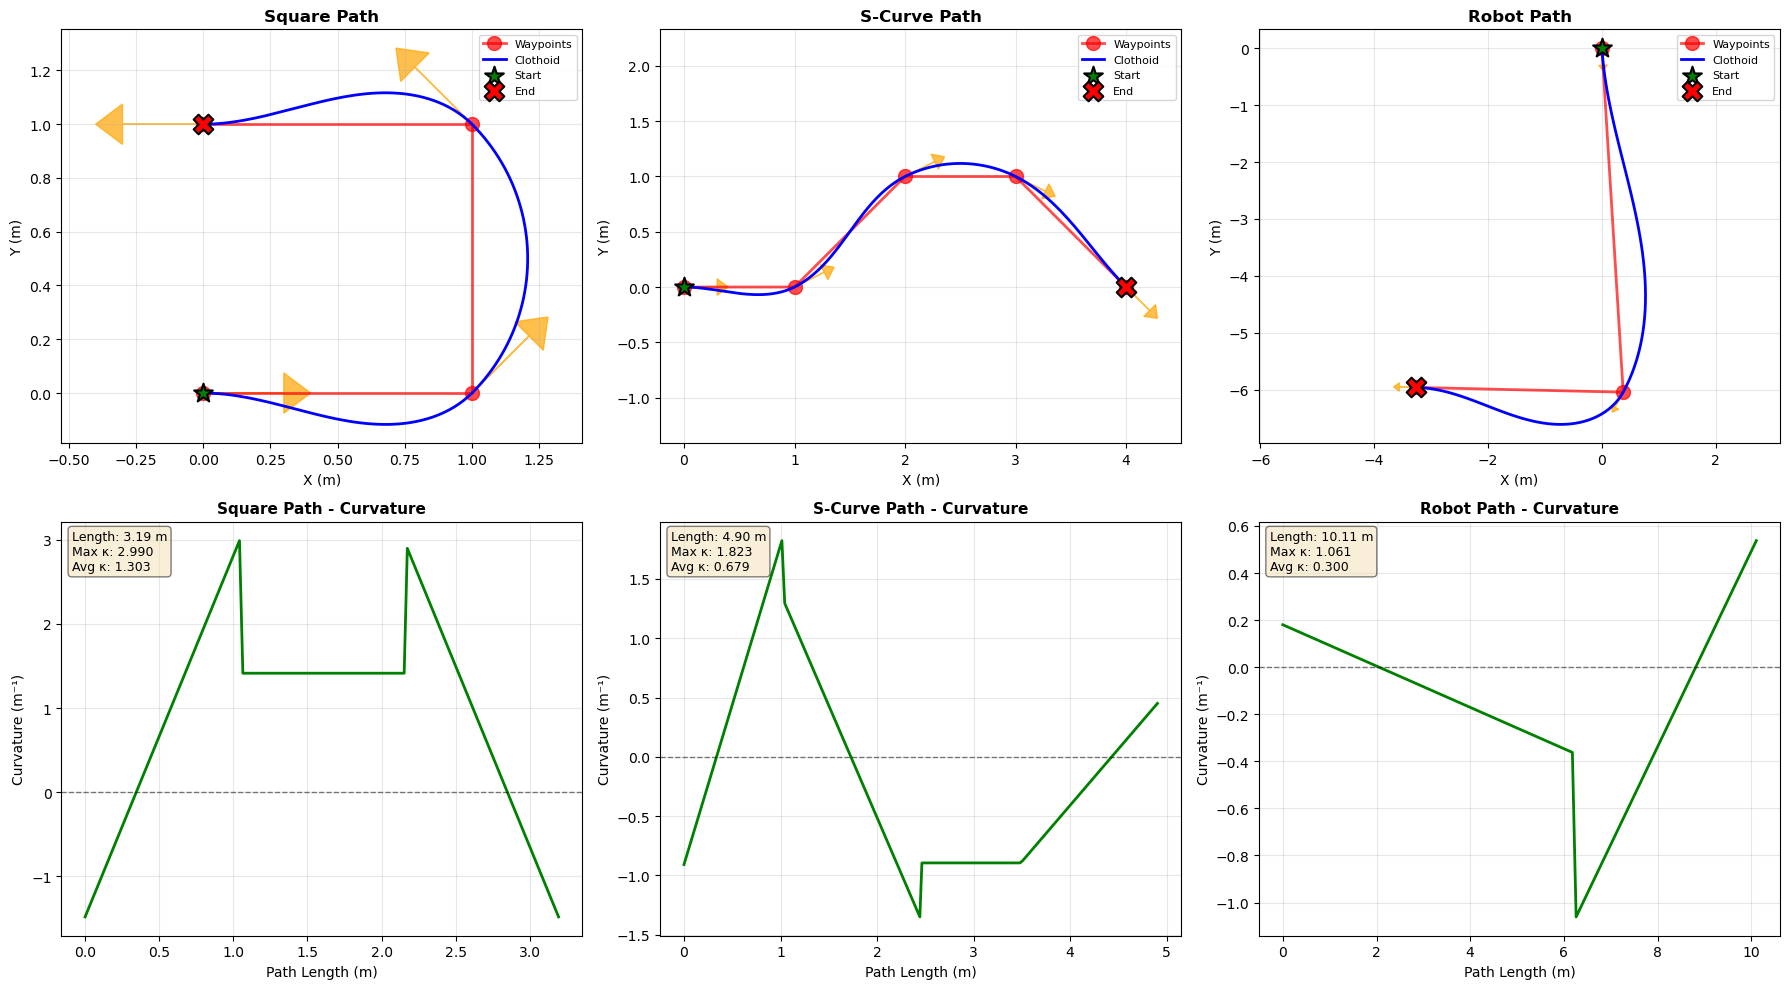

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Test cases for visualization
test_cases = [
    (square, 'Square Path'),
    (s_curve, 'S-Curve Path'),
    (robot_path, 'Robot Path')
]

for idx, (waypoints, title) in enumerate(test_cases):
    # Compute tangent angles
    tangent_angles = compute_tangent_angles(waypoints)
    
    # Generate clothoid segments
    all_x = []
    all_y = []
    all_curvatures = []
    
    for i in range(len(waypoints) - 1):
        x0, y0 = waypoints[i]
        x1, y1 = waypoints[i + 1]
        theta0 = tangent_angles[i]
        theta1 = tangent_angles[i + 1]
        
        # Create clothoid
        clothoid = Clothoid.G1Hermite(x0, y0, theta0, x1, y1, theta1)
        
        # Sample
        num_samples = 50
        x_seg, y_seg = clothoid.SampleXY(num_samples)
        curvatures_seg = compute_segment_curvatures(clothoid, num_samples)
        
        # Append (skip first point of subsequent segments)
        if i == 0:
            all_x.extend(x_seg)
            all_y.extend(y_seg)
            all_curvatures.extend(curvatures_seg)
        else:
            all_x.extend(x_seg[1:])
            all_y.extend(y_seg[1:])
            all_curvatures.extend(curvatures_seg[1:])
    
    # Convert to arrays
    x_smooth = np.array(all_x)
    y_smooth = np.array(all_y)
    curvatures = np.array(all_curvatures)
    
    # Compute distances
    dx = np.diff(x_smooth)
    dy = np.diff(y_smooth)
    distances = np.sqrt(dx**2 + dy**2)
    distances = np.concatenate([[0], distances])
    cumulative_dist = np.cumsum(distances)
    
    # Plot 1: Path comparison (top row)
    ax = axes[0, idx]
    ax.plot(waypoints[:, 0], waypoints[:, 1], 'ro-', 
            label='Waypoints', markersize=10, linewidth=2, alpha=0.7)
    ax.plot(x_smooth, y_smooth, 'b-', 
            label='Clothoid', linewidth=2)
    
    # Mark start and end
    ax.scatter(waypoints[0, 0], waypoints[0, 1], c='green', s=200, 
               marker='*', label='Start', zorder=5, edgecolors='black', linewidth=1.5)
    ax.scatter(waypoints[-1, 0], waypoints[-1, 1], c='red', s=200, 
               marker='X', label='End', zorder=5, edgecolors='black', linewidth=1.5)
    
    # Draw tangent arrows at waypoints
    for i, (x, y) in enumerate(waypoints):
        theta = tangent_angles[i]
        dx_arrow = 0.3 * np.cos(theta)
        dy_arrow = 0.3 * np.sin(theta)
        ax.arrow(x, y, dx_arrow, dy_arrow, head_width=0.15, 
                head_length=0.1, fc='orange', ec='orange', alpha=0.7)
    
    ax.set_xlabel('X (m)', fontsize=10)
    ax.set_ylabel('Y (m)', fontsize=10)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')
    
    # Plot 2: Curvature profile (bottom row)
    ax = axes[1, idx]
    ax.plot(cumulative_dist, curvatures, 'g-', linewidth=2)
    ax.set_xlabel('Path Length (m)', fontsize=10)
    ax.set_ylabel('Curvature (m⁻¹)', fontsize=10)
    ax.set_title(f'{title} - Curvature', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add statistics text
    max_curv = np.max(np.abs(curvatures))
    avg_curv = np.mean(np.abs(curvatures))
    path_length = cumulative_dist[-1]
    
    stats_text = f'Length: {path_length:.2f} m\nMax κ: {max_curv:.3f}\nAvg κ: {avg_curv:.3f}'
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('clothoid_smoother_test_results.png', dpi=150, bbox_inches='tight')
print("✓ Visualization complete")
print("✓ Saved as: clothoid_smoother_test_results.png\n")
plt.show()
